<a href="https://colab.research.google.com/github/AckermanLevi1/BTP-1/blob/main/Btech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

In [3]:
import simpy
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
class DemandGenerator:
    def __init__(self):
        self.demand_probabilities = [0.7, 0.15, 0.15]
        self.demand_values = [100000, 150000, 200000]

    def generate_demand(self):
        demand = random.choices(self.demand_values, self.demand_probabilities)[0]
        return demand

#### Retailer

In [5]:
class Retailer:
    def __init__(self, env, wholesaler):
        self.env = env
        self.wholesaler = wholesaler
        self.demand_generator = DemandGenerator()
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0
        self.holding_cost = 0.5
        self.shortage_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.lead_time = random.randint(1,4)
        self.action = env.process(self.run())


    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.shortage_cost/(self.shortage_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.wholesaler.receive_order(order)
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)

    def run(self):
        while True:
          self.receive_order()
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.shortage_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()

    def receive_order(self):
      demand = self.demand_generator.generate_demand()
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder




#### Wholesaler

In [6]:
class Wholesaler:
    def __init__(self, env, distributor):
        self.env = env
        self.distributor = distributor
        self.lead_time = random.randint(1,4)
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0
        self.holding_cost = 0.5
        self.shortage_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())


    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.shortage_cost/(self.shortage_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.distributor.receive_order(order)
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)

    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.shortage_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()


    def receive_order(self, demand):
        self.demandList.append(demand)
        if self.inventory < demand:
            self.outgoingOrder = self.inventory
        else:
            self.outgoingOrder = demand
        self.inventory -= self.outgoingOrder
        return self.outgoingOrder


#### Distributor

In [7]:
class Distributor:
    def __init__(self, env, factory):
        self.env = env
        self.factory = factory
        self.lead_time = random.randint(1,4)
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0
        self.holding_cost = 0.5
        self.shortage_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())

    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.shortage_cost/(self.shortage_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.factory.receive_order(order)
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)


    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.shortage_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()

    def receive_order(self, demand):
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder
      return self.outgoingOrder

#### Factory

In [8]:
class Factory:
    def __init__(self, env):
        self.env = env
        self.lead_time = random.randint(1,4)
        self.productionOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0
        self.holding_cost = 0.5
        self.shortage_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())

    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.shortage_cost/(self.shortage_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## producing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.inventory += order
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)

    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.shortage_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()

    def receive_order(self, demand):
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder
      return self.outgoingOrder

#### Simulation

In [58]:
def run_simulation():
    env = simpy.Environment()

    factory = Factory(env)
    distributor = Distributor(env, factory)
    wholesaler = Wholesaler(env, distributor)
    retailer = Retailer(env, wholesaler)

    env.process(retailer.run())
    env.process(wholesaler.run())
    env.process(distributor.run())
    env.process(factory.run())

    env.run(until=20)  # Run the simulation for 20 time steps

    print("Retailer demandList:", retailer.demandList)
    print("Wholesaler demandList:", wholesaler.demandList)
    print("Distributor demandList:", distributor.demandList)
    print("Factory demandList:", factory.demandList)

    print("Retailer optimalQtyList:", retailer.optimalQtyList)
    print("Wholesaler optimalQtyList:", wholesaler.optimalQtyList)
    print("Distributor optimalQtyList:", distributor.optimalQtyList)
    print("Factory optimalQtyList:", factory.optimalQtyList)

    print("Retailer OrderList:", retailer.OrderList)
    print("Wholesaler OrderList:", wholesaler.OrderList)
    print("Distributor OrderList:", distributor.OrderList)
    print("Factory OrderList:", factory.OrderList)

    print("Retailer inventoryList:", retailer.inventoryList)
    print("Wholesaler inventoryList:", wholesaler.inventoryList)
    print("Distributor inventoryList:", distributor.inventoryList)
    print("Factory inventoryList:", factory.inventoryList)

    print("Retailer costs:", retailer.costs)
    print("Wholesaler costs:", wholesaler.costs)
    print("Distributor costs:", distributor.costs)
    print("Factory costs:", factory.costs)

    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# # Plot weekly costs with moving average
    window_size = 2 # Adjust window size as needed
#     plt.plot(moving_average(retailer.costs, window_size), label='Retailer')
#     plt.plot(moving_average(wholesaler.costs, window_size), label='Wholesaler')
#     plt.plot(moving_average(distributor.costs, window_size), label='Distributor')
#     plt.plot(moving_average(factory.costs, window_size), label='Factory')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Weekly Costs ($)')
#     plt.title('Weekly Costs of Each Entity (Moving Average)')
#     plt.legend()
#     plt.show()

# Plot weekly inventory with moving average
    # plt.plot(moving_average(distributor.inventoryList, window_size), label='Retailer')
    # plt.plot(moving_average(wholesaler.inventoryList, window_size), label='Wholesaler')
    # plt.plot(moving_average(retailer.inventoryList, window_size), label='Distributor')
    # plt.plot(moving_average(factory.inventoryList, window_size), label='Factory')
    # plt.xlabel('Time Steps')
    # plt.ylabel('Weekly Inventory (Qty)')
    # plt.title('Weekly Inventory of Each Entity (Moving Average)')
    # plt.legend()
    # plt.show()

# Plot weekly order with moving average
    # plt.plot(moving_average(factory.OrderList, window_size), label='Retailer')
    plt.plot(moving_average(wholesaler.OrderList, window_size), label='Factory')
    plt.plot(moving_average(distributor.OrderList, window_size), label='Retailer')
    # plt.plot(moving_average(retailer.OrderList, window_size), label='Factory')
    plt.xlabel('Time Steps')
    plt.ylabel('Weekly Order (Qty)')
    plt.title('Weekly Order of Each Entity (Moving Average)')
    plt.legend()
    plt.show()


Retailer demandList: [100000, 100000, 200000, 100000, 150000, 100000, 200000, 100000, 100000, 100000, 100000, 150000, 100000, 100000]
Wholesaler demandList: [100000.0, 153638.0, 143651.0, 147229.0, 141449.0, 154680.0, 149706.0, 107611.0, 142363.0, 108789.0, 141449.0, 115071.0]
Distributor demandList: [138371.0, 138371.0, 138371.0, 138371.0, 138371.0, 138371.0, 145245.0, 6874.0, 6874.0, 6874.0, 6874.0, 6874.0, 148107.0, 35810.0, 35810.0, 10033.0, 10033.0, 10033.0, 145795.0, 48410.0, 48410.0, 15015.0, 15015.0, 15015.0, 143454.0, 52919.0, 52919.0, 19386.0, 19386.0, 19386.0, 142008.0, 55281.0, 55281.0, 23351.0]
Factory demandList: [138371.0, 138371.0, 138371.0, 138371.0, 138371.0, 138371.0, 141690.0, 141690.0, 125773.0, 125773.0, 112297.0, 112297.0, 112906.0, 87129.0, 104881.0, 104881.0, 97385.0, 97385.0, 99752.0, 66357.0, 95351.0, 95351.0, 90535.0, 90535.0, 92974.0, 59441.0, 90132.0, 90132.0, 86727.0, 86727.0, 88984.0, 57054.0, 86970.0]
Retailer optimalQtyList: [100000.0, 153638.0, 143651

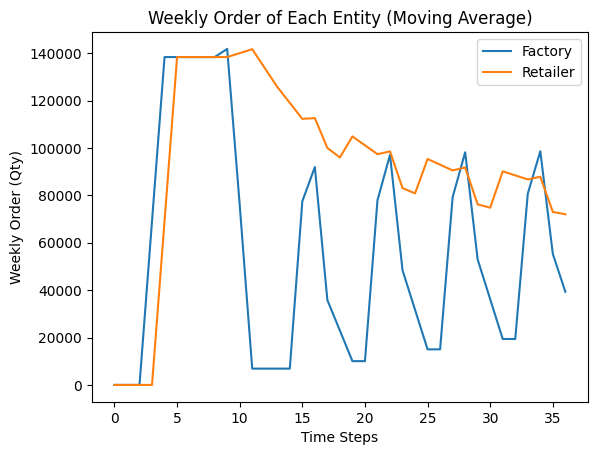

In [62]:
run_simulation()